https://mindbigdata.com/opendb/

https://github.com/search?q=mindbigdata&type=repositories

https://github.com/KrishnaVeer7712/DIGITS-CLASSIFICATIONS-USING-ELECTROENCEPHALOGRAPHY-SIGNALS/blob/master/Brain_123%20(1).ipynb

https://medium.com/@caelenhilty/mindnist-29f6fdda948d

FFT

https://github.com/KrishnaVeer7712/DIGITS-CLASSIFICATIONS-USING-ELECTROENCEPHALOGRAPHY-SIGNALS/blob/master/Brain_123%20(1).ipynb

In [134]:
import pandas as pd
import numpy as np


data_path = "data/muse_digit/MU.txt"

df_mu = pd.read_csv(data_path, sep='\t', header=None)



In [135]:
df_mu.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df_mu['data'] = df_mu['data'].apply(lambda x: list(map(float, x.split(','))))
df_mu.head()

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"[475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479..."
1,978112,132669,MU,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491..."
2,978113,132669,MU,FP2,6,459,"[482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470..."
3,978114,132669,MU,TP10,6,459,"[470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469..."
4,978115,132670,MU,TP9,7,493,"[506.0, 499.0, 495.0, 491.0, 492.0, 507.0, 496..."


In [136]:
df_mu["code"].unique()

array([ 6,  7,  1,  8,  9,  3,  2,  0,  5,  4, -1])

In [137]:
# count -1 in code
df_mu[df_mu["code"] == -1].shape[0]

44412

In [138]:
from scipy.signal import resample

def resample_signal(signal, original_rate, target_rate=128):
    num_samples = int(len(signal) * target_rate / original_rate)
    return resample(signal, num_samples)

# Sampling rates of each device
sampling_rates = {
    'MW': 512,  # MindWave
    'EP': 128,  # Emotiv Epoc
    'MU': 220,  # Interaxon Muse / Muse 2
    'IN': 128   # Emotiv Insight
}

# Resample the 'data' column for each device
def resample_device_data(df, device):
    original_rate = sampling_rates[device]
    df["data"] = df["data"].apply(lambda x: resample_signal(x, original_rate))
    return df

df_mu = resample_device_data(df_mu, 'MU')

In [139]:
df_mu.head()

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"[484.3149200961443, 472.9166828166159, 488.617..."
1,978112,132669,MU,FP1,6,459,"[482.64669910453273, 487.5481207646806, 497.97..."
2,978113,132669,MU,FP2,6,459,"[484.0855802516752, 483.9781153785091, 496.457..."
3,978114,132669,MU,TP10,6,459,"[481.171469454942, 471.135925840251, 492.58147..."
4,978115,132670,MU,TP9,7,493,"[510.1667114858209, 493.34613587679917, 493.54..."


In [140]:
import scipy.fft as fft

def bandpass_filter(signal: np.array, sample_rate: int = 250, do_filter: bool = True,
                         low_cut=1, high_cut=35, max_cut=45) -> tuple:
    """Performs a bandpass filter on the signal:
    (1) Frequencies above max_cut are removed (power set to zero)
    (2) Between 0 Hz and low_cut and between high_cut and max_cut will be attenuated using a raised cosine filter.
    Between low_cut and high_cut is unchanged.
    """
    assert signal.ndim == 1, "signal should be 1-D"
    assert sample_rate > 0, "sample_rate should be a positive integer in Hz"
    
    # mirror signal to reduce transform artifacts
    signal_mirror = np.append(signal, np.flip(signal))
    
    # fast Fourier transform
    signal_fft = fft.fft(signal_mirror)
    freqs = fft.fftfreq(len(signal_mirror), 1/sample_rate)
    
    if do_filter:
        abs_freqs = np.abs(freqs)
        
        # low-pass filter with raised cosine interpolation between `high_cut` and `max_cut`
        signal_fft[abs_freqs>max_cut] = 0
        interp_range = (abs_freqs>high_cut) & (abs_freqs<=max_cut)
        signal_fft[interp_range] *= 0.5 * (1 + np.cos(np.pi * (abs_freqs[interp_range]-high_cut)/(high_cut-max_cut)))
        
        # high-pass filter
        signal_fft[abs_freqs<low_cut] *= 0.5 * ( 1 + np.cos(np.pi * (abs_freqs[abs_freqs<low_cut]-low_cut)/low_cut))
    
    reconstructed = fft.ifft(signal_fft) # inverse fast Fourier transform
    reconstructed = reconstructed.real # take only real component
    reconstructed = reconstructed[:signal.shape[0]] # undo mirror
    
    # realign means
    reconstructed = reconstructed - np.mean(reconstructed) + np.mean(signal)
    
    return signal_fft, freqs, reconstructed

In [141]:
df_mu_copy = pd.concat([df_mu.drop(['data'], axis=1), df_mu['data'].apply(pd.Series)], axis=1)

In [142]:
df_mu.head()

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"[484.3149200961443, 472.9166828166159, 488.617..."
1,978112,132669,MU,FP1,6,459,"[482.64669910453273, 487.5481207646806, 497.97..."
2,978113,132669,MU,FP2,6,459,"[484.0855802516752, 483.9781153785091, 496.457..."
3,978114,132669,MU,TP10,6,459,"[481.171469454942, 471.135925840251, 492.58147..."
4,978115,132670,MU,TP9,7,493,"[510.1667114858209, 493.34613587679917, 493.54..."


In [143]:
df_mu_copy.head()

,id,event,device,channel,code,size,0,1,2,3,...,346,347,348,349,350,351,352,353,354,355
0,978111,132669,MU,TP9,6,459,484.314920,472.916683,488.617285,475.690049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,978112,132669,MU,FP1,6,459,482.646699,487.548121,497.978439,491.600839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,978113,132669,MU,FP2,6,459,484.085580,483.978115,496.457527,467.557943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,978114,132669,MU,TP10,6,459,481.171469,471.135926,492.581477,471.002992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,978115,132670,MU,TP9,7,493,510.166711,493.346136,493.545388,500.445076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# "data" column is an array of floats get the max length of the array
max_len = df_mu["data"].apply(len).max()
print(max_len)

# check the max number in the copied dataframe
print(df_mu_copy.columns[-1])
assert max_len == df_mu_copy.columns[-1] + 1

356
355


In [145]:
# get columns that are not string
crucial_columns = ['id', 'event', 'device', 'channel', 'code', 'size']

# get non crucial columns
non_crucial_columns = [col for col in df_mu_copy.columns if col not in crucial_columns]

print(non_crucial_columns)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [146]:
from sklearn.preprocessing import MinMaxScaler

data = df_mu[['data']].values

# find how many rows have channel TP9
print(df_mu[df_mu["channel"] == "TP9"].shape[0])

# have to have min max scaler for each channel
tp9_scaler = MinMaxScaler()
tp10_scaler = MinMaxScaler()
fp1_scaler = MinMaxScaler()
fp2_scaler = MinMaxScaler()

# change rows with channel tp9 to tp9_scaler
print("all data shape", df_mu_copy.shape)
tp9_data = df_mu_copy[df_mu_copy["channel"] == "TP9"][non_crucial_columns].values
print(tp9_data.shape)
scaled_tp9 = tp9_scaler.fit_transform(tp9_data)
print(scaled_tp9.shape)

# bandpassfilter for each row 
# bandpass_tp9 = []
# for i in range(len(scaled_tp9)):
#     _, _, data = bandpass_filter(scaled_tp9[i])
#     bandpass_tp9.append(data)

tp10_data = df_mu_copy[df_mu_copy["channel"] == "TP10"][non_crucial_columns].values
scaled_tp10 = tp10_scaler.fit_transform(tp10_data)
print(scaled_tp10.shape)

# bandpass_tp10 = []
# for i in range(len(scaled_tp10)):
#     _, _, data = bandpass_filter(scaled_tp10[i])
#     bandpass_tp10.append(data)

fp1_data = df_mu_copy[df_mu_copy["channel"] == "FP1"][non_crucial_columns].values
scaled_fp1 = fp1_scaler.fit_transform(fp1_data)
print(scaled_fp1.shape)

# bandpass_fp1 = []
# for i in range(len(scaled_fp1)):
#     _, _, data = bandpass_filter(scaled_fp1[i])
#     bandpass_fp1.append(data)

fp2_data = df_mu_copy[df_mu_copy["channel"] == "FP2"][non_crucial_columns].values
scaled_fp2 = fp2_scaler.fit_transform(fp2_data)
print(scaled_fp2.shape)

# bandpass_fp2 = []
# for i in range(len(scaled_fp2)):
#     _, _, data = bandpass_filter(scaled_fp2[i])
#     bandpass_fp2.append(data)


# now create a new data frame with the scaled data
df_mu_scaled = df_mu_copy.copy()

# replace tp9 data with scaled data

df_mu_scaled.loc[df_mu_scaled["channel"] == "TP9", non_crucial_columns] = scaled_tp9
df_mu_scaled.loc[df_mu_scaled["channel"] == "TP10", non_crucial_columns] = scaled_tp10
df_mu_scaled.loc[df_mu_scaled["channel"] == "FP1", non_crucial_columns] = scaled_fp1
df_mu_scaled.loc[df_mu_scaled["channel"] == "FP2", non_crucial_columns] = scaled_fp2





# save the scaler for later use
import joblib

joblib.dump(tp9_scaler, "muse_tp9_scaler.pkl")
joblib.dump(tp10_scaler, "muse_tp10_scaler.pkl")
joblib.dump(fp1_scaler, "muse_fp1_scaler.pkl")
joblib.dump(fp2_scaler, "muse_fp2_scaler.pkl")


40983
all data shape (163932, 362)
(40983, 356)
(40983, 356)
(40983, 356)
(40983, 356)
(40983, 356)


['muse_fp2_scaler.pkl']

In [147]:
# save the df_mu_scaled
df_mu_scaled.to_csv("muse_scaled.csv", index=False)

In [148]:
df_mu_scaled[df_mu_scaled["channel"] == "TP9"].head()

,id,event,device,channel,code,size,0,1,2,3,...,346,347,348,349,350,351,352,353,354,355
0,978111,132669,MU,TP9,6,459,0.465526,0.481779,0.455826,0.451348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,978115,132670,MU,TP9,7,493,0.475589,0.488004,0.457492,0.459541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,978119,132671,MU,TP9,6,459,0.478587,0.499618,0.465431,0.470909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,978123,132672,MU,TP9,6,459,0.476842,0.499610,0.467771,0.465464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,978127,132673,MU,TP9,1,493,0.473231,0.490248,0.458183,0.461755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
df_mu_scaled[df_mu_scaled["channel"] == "TP10"].head()

,id,event,device,channel,code,size,0,1,2,3,...,346,347,348,349,350,351,352,353,354,355
3,978114,132669,MU,TP10,6,459,0.433747,0.477745,0.456997,0.490291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,978118,132670,MU,TP10,7,493,0.445314,0.485110,0.455401,0.500741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,978122,132671,MU,TP10,6,459,0.451556,0.497890,0.464848,0.510355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,978126,132672,MU,TP10,6,459,0.449070,0.496274,0.471316,0.502242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,978130,132673,MU,TP10,1,493,0.442722,0.486765,0.453581,0.502663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
df_mu_scaled.head()

,id,event,device,channel,code,size,0,1,2,3,...,346,347,348,349,350,351,352,353,354,355
0,978111,132669,MU,TP9,6,459,0.465526,0.481779,0.455826,0.451348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,978112,132669,MU,FP1,6,459,0.516481,0.518012,0.534880,0.510132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,978113,132669,MU,FP2,6,459,0.418983,0.429396,0.424359,0.424315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,978114,132669,MU,TP10,6,459,0.433747,0.477745,0.456997,0.490291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,978115,132670,MU,TP9,7,493,0.475589,0.488004,0.457492,0.459541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# check the number of nana values in the data
df_mu_scaled.isnull().sum().sum()

np.int64(13784012)

In [152]:
# this gives the null values of each column
l=df_mu_scaled.isnull().sum()
c=0
col_idx = 0
for i in l:
  c=c+1
  if(i!=0):
    print(c, i)
    print(df_mu_scaled[column].isnull().sum())
    break
  column = df_mu_scaled.columns[c-1]
  col_idx = c-1
print(column)

if col_idx != 0:
  cols_to_remove = range(col_idx, len(df_mu_scaled.columns))

  df_mu_scaled.drop(df_mu_scaled.columns[cols_to_remove], axis=1, inplace=True)

  df_mu_scaled.head()


244 312
0
236


In [153]:
# now we have all data
df_mu_scaled.isnull().sum().sum()

np.int64(0)

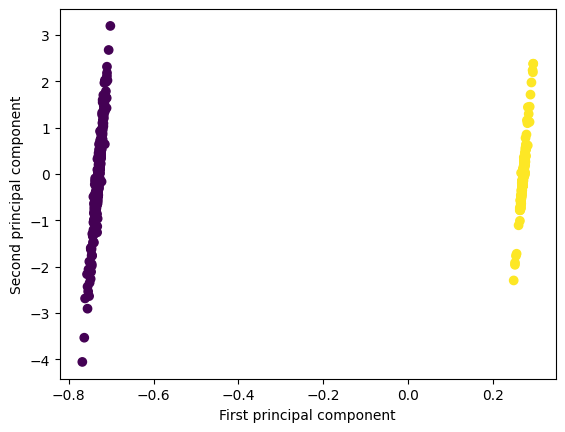

In [154]:
# let us to pca between -1 and non -1 values
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# get the data between -1 and non -1 values
# Filter with .copy() to avoid SettingWithCopyWarning
non_minus_1 = df_mu_scaled[df_mu_scaled["code"] != -1].copy()
minus_1 = df_mu_scaled[df_mu_scaled["code"] == -1].copy()

# Get tp9 data and create copies
non_minus_1_tp9 = non_minus_1[non_minus_1["channel"] == "TP9"].copy()
minus_1_tp9 = minus_1[minus_1["channel"] == "TP9"].copy()

# Set values
non_minus_1_tp9["is_num"] = 1
minus_1_tp9["is_num"] = 0

all_tp9 = pd.concat([non_minus_1_tp9, minus_1_tp9])


predictor_columns = [col for col in all_tp9.columns if col not in crucial_columns]

# now we will plot the pca of the data by 0 and 1
pca = PCA(n_components=2)

X = all_tp9[predictor_columns].values
y_binary = all_tp9["is_num"].values
y_code = all_tp9["code"].values


X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap='viridis')
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_code, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()





In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the adapted model with Conv1D, LSTM, and Dense layers
# Example LSTM model



class BrainWaveLSTM(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size, num_layers=1):
        super(BrainWaveLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output
        out = self.fc(out[:, -1, :])
        return out



In [156]:
print(all_tp9.isna().sum().sum())
print(all_tp10.isna().sum().sum())
print(all_fp1.isna().sum().sum())
print(all_fp2.isna().sum().sum())

print(all_tp9.shape)
print(all_tp10.shape)
print(all_fp1.shape)
print(all_fp2.shape)


0
0
0
0
(40983, 243)
(40983, 242)
(40983, 242)
(40983, 242)


In [157]:
# count value of -1 in code
print(df_mu_scaled[df_mu_scaled["code"] == -1].shape[0])

# non digit value ratio
print(df_mu_scaled[df_mu_scaled["code"] == -1].shape[0] / df_mu_scaled.shape[0])

44412
0.2709172095747017


In [ ]:
all_tp9 = df_mu_scaled[df_mu_scaled["channel"] == "TP9"]
all_tp9.loc[all_tp9["code"] == -1, "code"] = 10
all_tp10 = df_mu_scaled[df_mu_scaled["channel"] == "TP10"]
all_tp10.loc[all_tp10["code"] == -1, "code"] = 10
all_fp1 = df_mu_scaled[df_mu_scaled["channel"] == "FP1"]
all_fp1.loc[all_fp1["code"] == -1, "code"] = 10
all_fp2 = df_mu_scaled[df_mu_scaled["channel"] == "FP2"]
all_fp2.loc[all_fp2["code"] == -1, "code"] = 10

# remove the code 10
# all_tp9 = all_tp9[all_tp9["code"] != 10]
# all_tp10 = all_tp10[all_tp10["code"] != 10]
# all_fp1 = all_fp1[all_fp1["code"] != 10]
# all_fp2 = all_fp2[all_fp2["code"] != 10]

# fft

# count how much each code is in the data
print(all_tp9["code"].value_counts())

predictor_columns = [col for col in all_tp9.columns if col not in crucial_columns]

# we will create X by creating a 4 channel data for each row
X = []
y = []

for i in range(all_tp9.shape[0]):
    tp9 = all_tp9.iloc[i][predictor_columns].values
    tp10 = all_tp10.iloc[i][predictor_columns].values
    fp1 = all_fp1.iloc[i][predictor_columns].values
    fp2 = all_fp2.iloc[i][predictor_columns].values
    X.append(np.array([tp9, tp10, fp1, fp2], dtype=np.float32))
    # print(all_tp9.iloc[i]["code"])
    # if code is 10 change it to 0
    if all_tp9.iloc[i]["code"] == 10:
        y.append(0)
    else:
        y.append(1)

X = np.array(X)
# change the shape to (batch, sequence, channels)
X = np.transpose(X, (0, 2, 1))
y = np.array(y)
print(X.shape, y.shape)

code
10    11103
6      3092
8      3052
7      3020
5      3013
9      2997
2      2980
0      2976
3      2958
1      2908
4      2884
Name: count, dtype: int64
(40983, 236, 4) (40983,)


In [173]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tqdm import tqdm

# Assuming y and predictor_columns are defined
knn = KNeighborsClassifier(n_neighbors=3)

# Concatenate all channels for KNN input
knn_tp9 = all_tp9[predictor_columns].values
knn_tp10 = all_tp10[predictor_columns].values
knn_fp1 = all_fp1[predictor_columns].values
knn_fp2 = all_fp2[predictor_columns].values
# knn_X = np.concatenate((knn_tp9, knn_tp10, knn_fp1, knn_fp2), axis=1)
print(knn_tp9.shape)
knn_X = np.concatenate((knn_tp9, knn_tp10), axis=1)

print(knn_X.shape)

# from scipy.fftpack import fft, ifft

# knn_X = np.abs(fft(knn_X))

# Cross-validation setup
skf = StratifiedKFold(n_splits=5)

# Function to evaluate each fold
def evaluate_fold(train_idx, test_idx):
    X_train, X_test = knn_X[train_idx], knn_X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    return accuracy_score(y_test, predictions)

# Perform cross-validation with progress tracking
cv_scores = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx)
    for train_idx, test_idx in tqdm(skf.split(knn_X, y), total=skf.get_n_splits())
)

# Display each fold's score and the average score
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))


(40983, 236)
(40983, 472)


100%|██████████| 5/5 [00:00<00:00, 2202.66it/s]


Cross-validation scores for each fold: [0.8403074295473953, 0.8462852263023057, 0.8274978650725875, 0.8321132259638848, 0.8509028794533919]
Average cross-validation score: 0.839421325267913


In [165]:
knn_X.shape

(40983, 472)

In [166]:
# save the knn model
joblib.dump(knn, "knn_model_binary.pkl")

['knn_model_binary.pkl']

In [178]:
# test knn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(knn_X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# check how many will not be 0
print(np.unique(predictions, return_counts=True))

Accuracy: 0.8395754544345492
(array([0, 1]), array([1109, 7088]))


In [185]:
value = knn.predict(X_test)

# get unique values and their counts
unique, counts = np.unique(value, return_counts=True)

print(np.asarray((unique, counts)).T)

joblib.dump(knn, "knn_model_binary.pkl")


[[   0 1109]
 [   1 7088]]


['knn_model_binary.pkl']

In [168]:
knn_X.shape

(40983, 472)

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

# Initialize the RandomForest model
rf = RandomForestClassifier(n_estimators=100)

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5)

# Function to evaluate each fold
def evaluate_fold(train_idx, test_idx):
    X_train, X_test = knn_X[train_idx], knn_X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    rf.fit(X_train, y_train)
    return rf.score(X_test, y_test)

# Perform cross-validation with progress tracking
cv_scores = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx)
    for train_idx, test_idx in tqdm(skf.split(knn_X, y), total=skf.get_n_splits())
)

# Display each fold's score and the average score
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

100%|██████████| 5/5 [00:00<00:00, 1782.53it/s]


Cross-validation scores for each fold: [0.9222886421861657, 0.8974014883493961, 0.9026473099914603, 0.9121522693997072, 0.9269155685700342]
Average cross-validation score: 0.9122810556993528


In [186]:
# fit a

# train the model

X_train, X_test, y_train, y_test = train_test_split(knn_X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

print(predictions)

[1 1 1 ... 1 1 1]


In [187]:
# save the rf model
joblib.dump(rf, "rf_model_muse_binary.joblib")


['rf_model_muse_binary.joblib']

In [190]:
value = rf.predict(X_test)

unique, counts = np.unique(value, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 2188]
 [   1 6009]]


In [171]:
all_tp9.shape

(40983, 242)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Parameters for sequence length and feature depth
sequence_length = X.shape[1]     # Set to 236 as per your data shape
input_channels = X.shape[-1]        # Set to 4 as per your data shape
hidden_size = 256
output_size = 11          # Number of classes (e.g., digits 0-9)
num_epochs = 5
batch_size = 128
learning_rate = 0.001

# Define model, loss function, and optimizer
model = BrainWaveLSTM(input_channels=input_channels, hidden_size=hidden_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create train and test sets


X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Train the model
# Train the model
for epoch in range(num_epochs):
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Evaluation after each epoch
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f'Accuracy after epoch {epoch+1}: {accuracy:.4f}')



Epoch [1/5], Step [10/187], Loss: 2.3834
Epoch [1/5], Step [20/187], Loss: 2.3121
Epoch [1/5], Step [30/187], Loss: 2.3050
Epoch [1/5], Step [40/187], Loss: 2.3161
Epoch [1/5], Step [50/187], Loss: 2.3074
Epoch [1/5], Step [60/187], Loss: 2.3289
Epoch [1/5], Step [70/187], Loss: 2.3165
Epoch [1/5], Step [80/187], Loss: 2.3087
Epoch [1/5], Step [90/187], Loss: 2.3086
Epoch [1/5], Step [100/187], Loss: 2.3054
Epoch [1/5], Step [110/187], Loss: 2.3074
Epoch [1/5], Step [120/187], Loss: 2.3007
Epoch [1/5], Step [130/187], Loss: 2.3143
Epoch [1/5], Step [140/187], Loss: 2.3310
Epoch [1/5], Step [150/187], Loss: 2.3072
Epoch [1/5], Step [160/187], Loss: 2.3015
Epoch [1/5], Step [170/187], Loss: 2.2977
Epoch [1/5], Step [180/187], Loss: 2.3014
Accuracy after epoch 1: 0.1009
Epoch [2/5], Step [10/187], Loss: 2.3303
Epoch [2/5], Step [20/187], Loss: 2.3002
Epoch [2/5], Step [30/187], Loss: 2.3128
Epoch [2/5], Step [40/187], Loss: 2.3058
Epoch [2/5], Step [50/187], Loss: 2.3101
Epoch [2/5], Step

In [53]:
# save the model
torch.save(model.state_dict(), "model_muse.pth")


In [102]:
# test the model
model.eval()

test_count = 1000

for i in range(test_count):
    random_idx = np.random.randint(0, X_test.shape[0])
    X_test_random = X_test[random_idx]

    output = model(X_test_random.unsqueeze(0))
    _, predicted = torch.max(output, 1)

    if(predicted.item() != 0):
        print(f'Predicted: {predicted.item()}, Actual: {y_test[random_idx].item()}')
